In [1]:
import pandas as pd
import numpy as np
from utils.od_utils import *

In [2]:
data_base_path = './result/'
od_path = data_base_path+'od_jan.npy'
pu_count_path = data_base_path+'pu_count_jan.csv'
zone_table_path = './data/taxi-data/taxi+_zone_lookup.csv'

In [3]:
zone_df = pd.read_csv(zone_table_path)

# Analysis on OD table: Plot top 10 PU Vs. DO
Original OD table is huge (265*265). We want to see "hot spots". In this case, top 10 PU and DO locations


In [4]:
od = np.load(od_path)
pu_count_df = pd.read_csv(pu_count_path)

In [5]:
# top 10 places to pick up
n = 10
top10_df = create_topn_od(n,pu_count_df,od,zone_df)

In [6]:
# top10_df.to_csv('result/top_10_pudo.csv',index=False)
top10_df

,pu_id,1,2,3,4,5,6,7,8,9,10
0,237,262,239,229,142,140,141,161,162,237,236
1,161,48,163,170,186,164,234,230,236,161,237
2,236,142,161,75,162,238,239,262,141,237,236
3,162,234,230,186,107,161,236,141,162,237,170
4,230,170,100,246,162,163,142,230,48,161,186
5,186,68,163,107,246,162,48,234,170,230,161
6,48,143,186,163,50,246,142,230,161,68,48
7,234,164,107,113,249,234,79,68,161,186,170
8,170,237,230,164,229,162,186,107,170,161,234
9,142,230,161,163,236,143,237,48,142,238,239


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


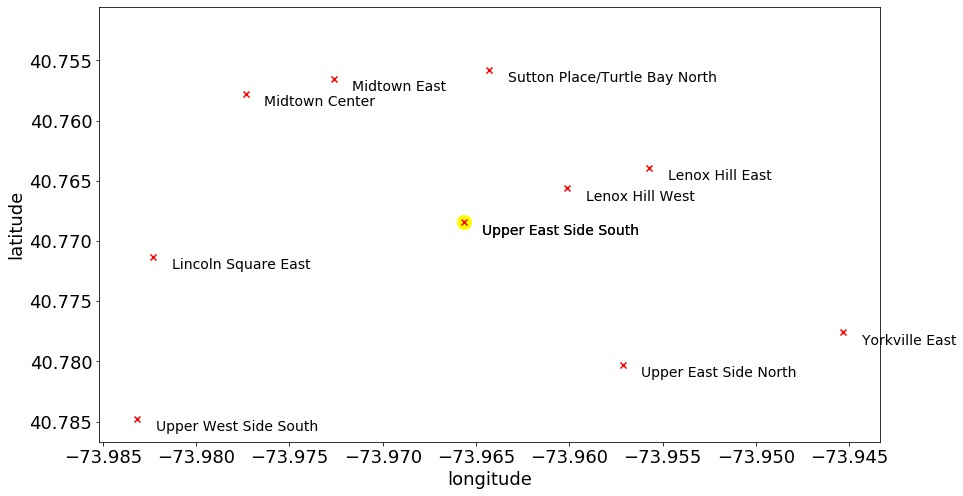

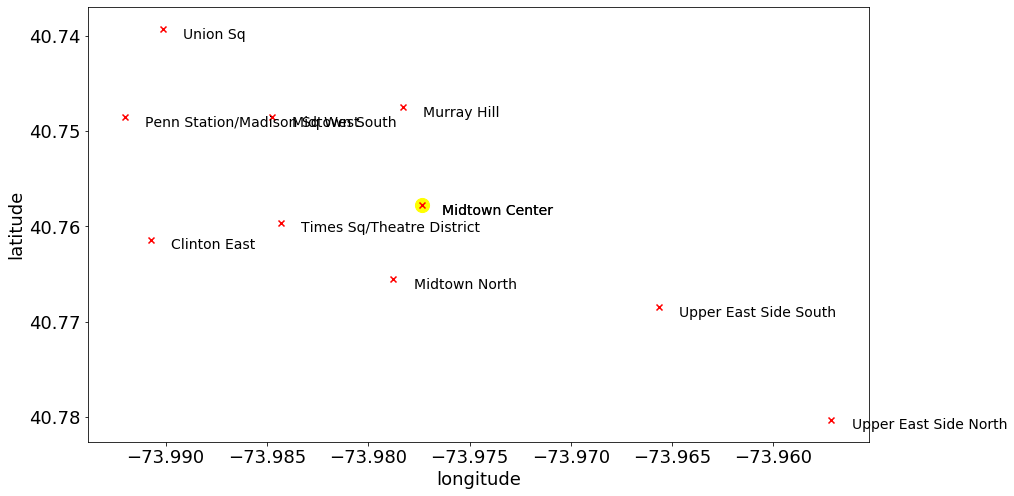

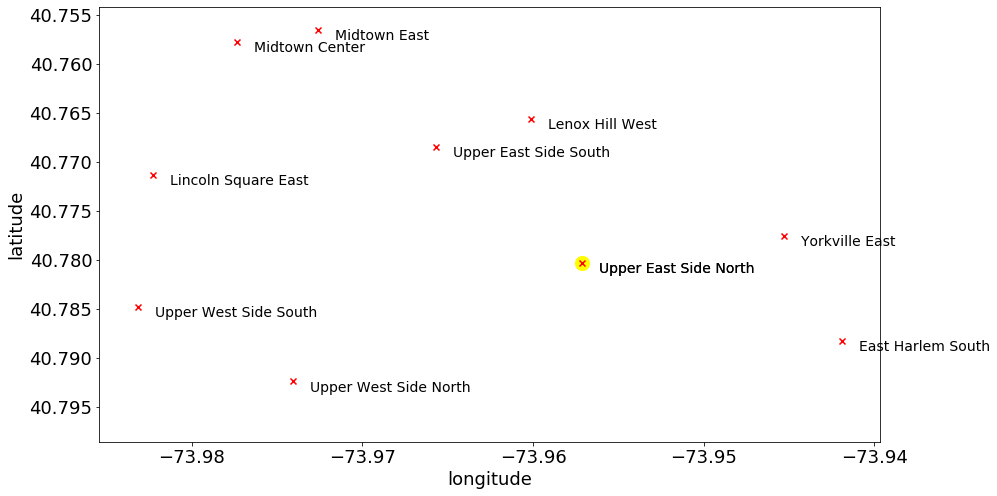

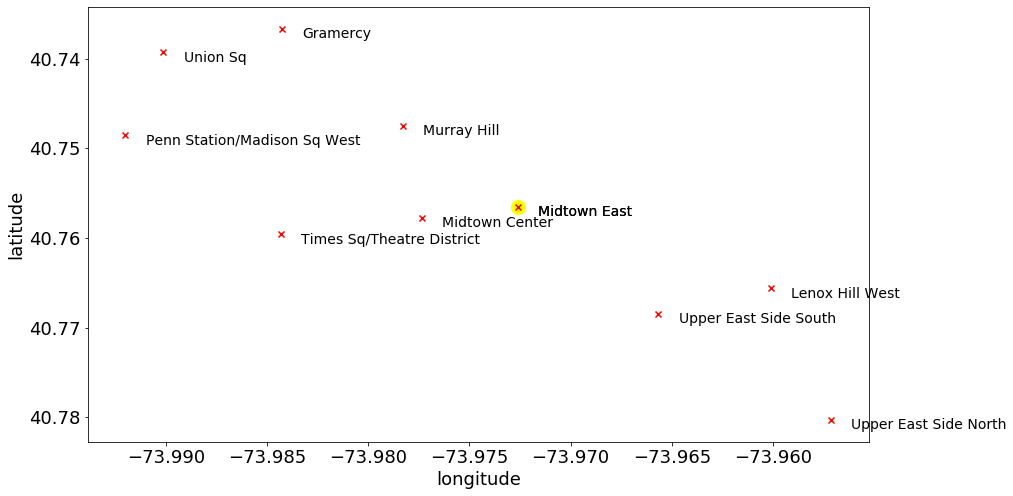

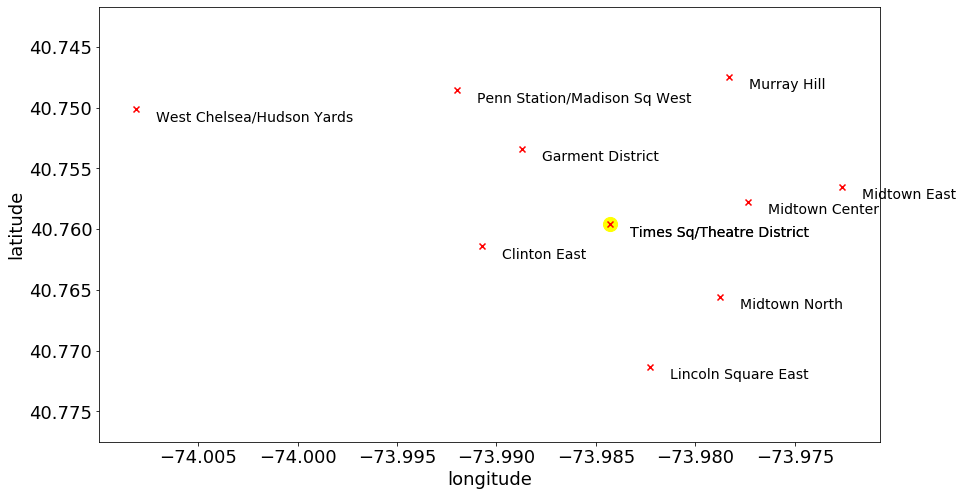

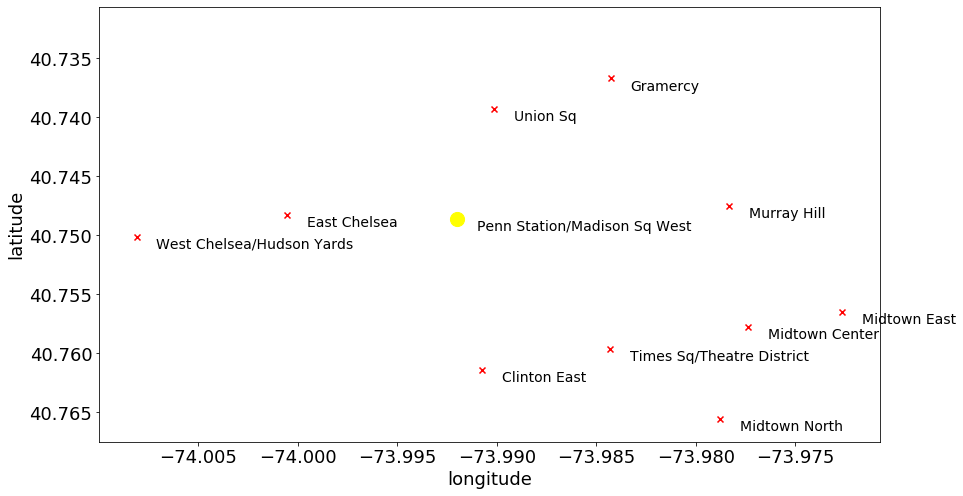

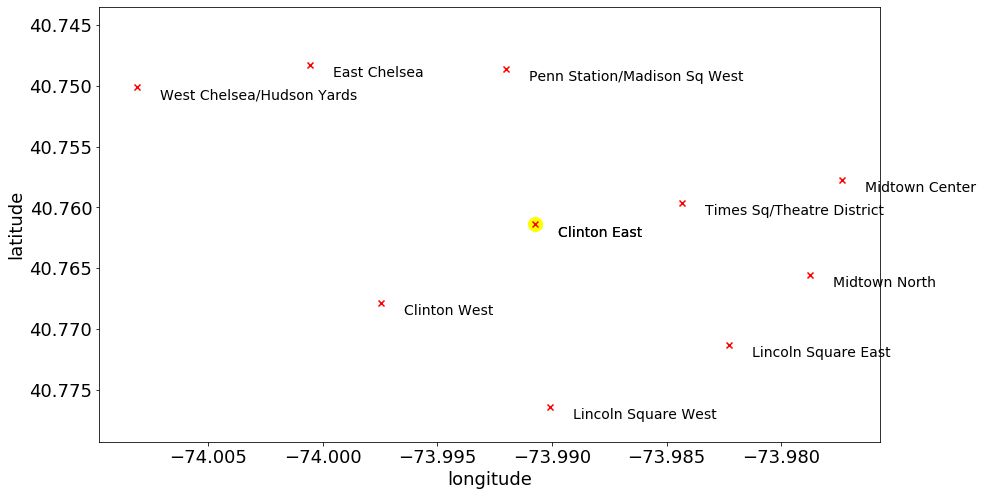

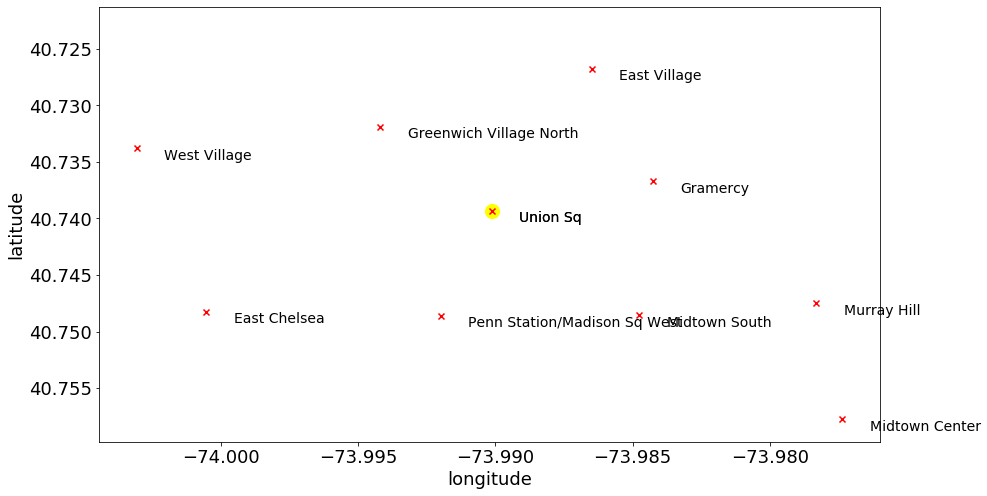

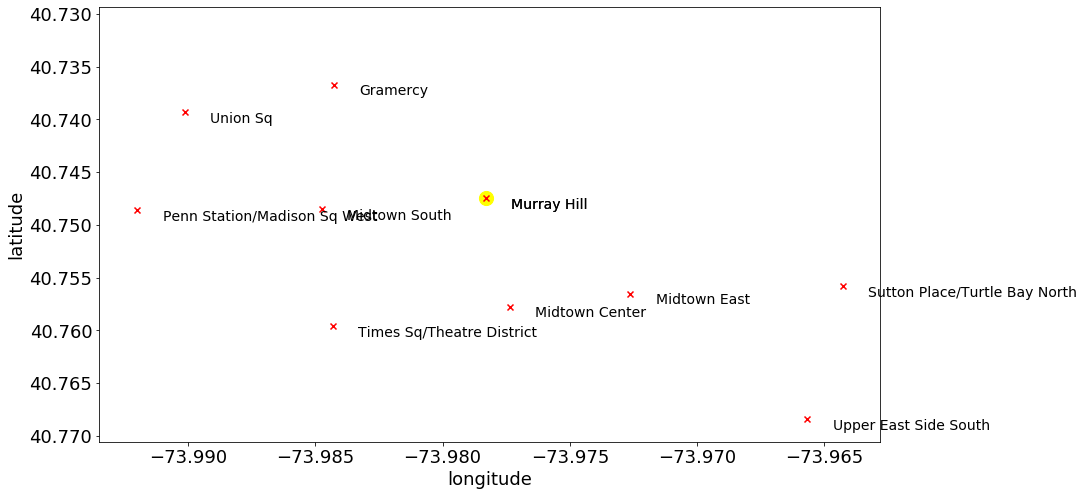

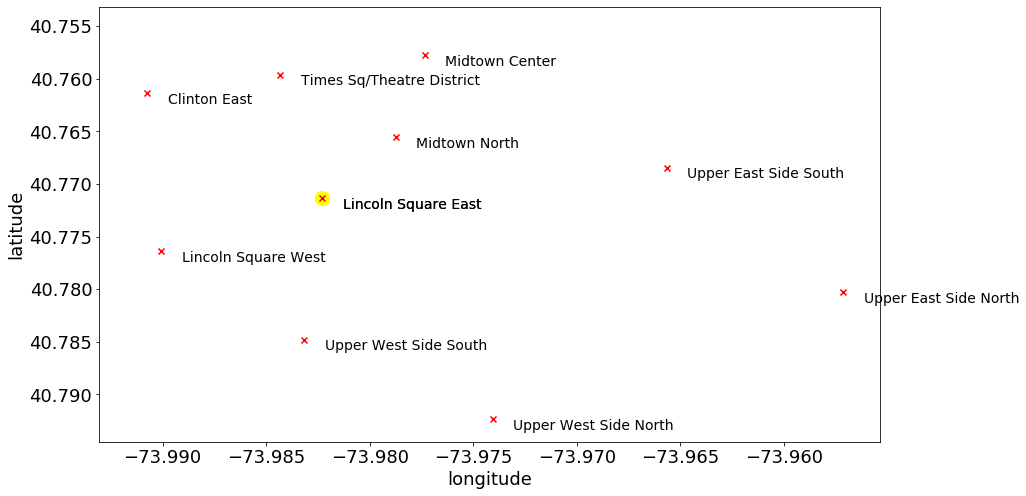

In [7]:
for i in range(10):
    row = top10_df.iloc[i]
    lat,long,loc_names = parse_plot_info(row,pu_count_df,zone_df)
    file_name = 'pu_do_jan_%d.png'%(i+1)
    plot_pu_do(lat,long,loc_names,'./result/figures/'+file_name)

# Analysis on OD table: Very Top 10
10*10 matrix may also be too large for decision making, Lets create a simple rank algorithm to select the very top 10 from the OD table:
- PU location score two points 
- DO location score one point
- As PU priority drops, a decay rate is introduced to decrease their priority on total score 
- Final score reveals the priority for the location

In [8]:
def find_top10_places(top10_df,decay_rate = 0.95):
    scores = {}
    for i in range(10):
        row = top10_df.iloc[i]
        decay_value = decay_rate**i
        scores = update_score(row,scores,decay_value)
    top10_places = get_topn_places(scores)
    return top10_places

def update_score(row,scores,decay_value):
    scores = scores.copy()
    loc_idxs = list(row)
    for i,loc_idx in enumerate(loc_idxs):
        if loc_idx not in scores:
            scores[loc_idx] = 0
        if i ==0:
            scores[loc_idx] +=decay_value*2
        else:
            scores[loc_idx] +=decay_value*1
    return scores

def get_topn_places(scores,n=10):
    sorted_scores = sorted(scores.items(), key=lambda kv: kv[1])[::-1]
    return sorted_scores[:n]
    

In [9]:
top10_places = find_top10_places(top10_df)

In [10]:
# ids to names
top10_places_name = []
for loc_id, score in top10_places:
    loc_name = translate_zone_code(zone_df,loc_id)
    top10_places_name.append((loc_name,score))
    

Here are the very top 10 locations for a yellow cab driver in NYC

In [11]:
top10_places_name

[('Midtown Center', 9.92526121523242),
 ('Times Sq/Theatre District', 7.053436419138671),
 ('Upper East Side South', 7.003544841013672),
 ('Midtown East', 6.726332618789062),
 ('Penn Station/Madison Sq West', 6.266292743007812),
 ('Upper East Side North', 6.145124409724609),
 ('Murray Hill', 6.084260777460936),
 ('Clinton East', 5.373812269099608),
 ('Lincoln Square East', 5.342846369798827),
 ('Union Sq', 5.339588257070312)]

In [12]:
# to csv for qgis plot
loc_ids = []
scores = []
for loc_id, score in top10_places:
    loc_ids.append(loc_id)
    scores.append(score)
    

In [14]:
top10_df = pu_count_df[pu_count_df['id'].isin(loc_ids)]
top10_df['score'] = scores
top10_df.to_csv('./result/top10_places_jan.csv',index = False)


/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
